In [1]:
import networkx as nx
import matplotlib as plt
import numpy as np
import pandas as pd


In [2]:
def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges      

def pathBand(path):
    path_len=len(path)
    #print(path)
    #print(path[0][0])
    resource=Resource[path[0][0]][path[0][1]][path[0][2]]
    for i in range(1,path_len):
        resource=list(map(lambda x: x[0]+x[1], zip(resource, Resource[path[i][0]][path[i][1]][path[i][2]])))
    pathbandList=zero_runs(resource) 
    
    return pathbandList

In [3]:
def pathBand_Ocuupy(loc1,loc2,band,index):
    path=SD_pathLink[loc1][loc2]
    pathBand=ALL_SD_bandwidth[loc1][loc2]
    waveflag=0
    for i in pathBand:        
        if ((i[1] - i[0])>=band and i[0]+band<=160):
            startwave=i[0]
            waveflag=1
            break
    if(waveflag==1):
        for i in range(len(path)):
            for j in range(band):
                Resource[path[i][0]][path[i][1]][path[i][2]][startwave+j]+=index+1
            
    return waveflag

        
def pathUpdate():
    SR_bandwidth=[]
    #MaxBand=[]
    Hops=[]
    for i in range(len(SD_pathLink)):
        band=[]
        #Max=[]
        hops=[]        
        for j in range(len(SD_pathLink[i])):
            #cost.append(pathCost(SD_pathLink[i][j]))
            hops.append(len(SD_pathLink[i][j]))
            b=pathBand(SD_pathLink[i][j])
            #Max.append(max(b[:,1] - b[:,0]))
            band.append(b)            
        #SR_pathLink_cost.append(cost)
        SR_bandwidth.append(band)
        #MaxBand.append(Max)
        Hops.append(hops)
    global ALL_SD_bandwidth
    ALL_SD_bandwidth=SR_bandwidth
        
    return

In [4]:
def CoreSetup():
    Nodes_list=list(G.nodes)
    #Link_bypass=[]
    for i in Nodes_list:
        neighborList=list(G.neighbors(i))
        #bypasscore_num=len(neighborList)-1# set the bypass core number within each fiber 
        for j in range(len(neighborList)):
            dis=1
            while(j+dis<len(neighborList)):
                input_loc=edges_list.index((neighborList[j],i))
                output_loc=edges_list.index((i,neighborList[j+dis]))
                successFlag=0
                for m in range(7):
                    if(len(bypassEdges[input_loc][m])==0):
                        for n in range(7):
                            if(len(bypassEdges[output_loc][n])==0):
                                bypassEdges[output_loc][n].append(((neighborList[j],i,m)))
                                bypassEdges[input_loc][m].append(((i,neighborList[j+dis],n)))
                                successFlag=1
                                break
                        if(successFlag==1):
                            break
                input_loc=edges_list.index((neighborList[j+dis],i))
                output_loc=edges_list.index((i,neighborList[j]))
                successFlag=0
                for m in range(7):
                    if(len(bypassEdges[input_loc][m])==0):
                        for n in range(7):
                            if(len(bypassEdges[output_loc][n])==0):
                                bypassEdges[output_loc][n].append(((neighborList[j+dis],i,m)))
                                bypassEdges[input_loc][m].append(((i,neighborList[j],n)))
                                successFlag=1
                                break
                        if(successFlag==1):
                            break
                                                                                                        
                dis+=1
    return;

In [5]:
def edgeToLinks(path):
    pathlist=[]
    path_len=len(path)
    corePossib=7**path_len
    for i in range(corePossib):
        List=[]
        List.append((path[0]+(i%7,)))
        edgeLoc=edges_list.index(path[0])
        
        if(len(In_bypassEdges[edgeLoc][i%7])>0):
            List=[]
            continue
        for j in range(1,path_len):
            List.append((path[j]+((int(i/(7**j)%7)),)))
            edgeLoc0=edges_list.index(path[j-1])
            edgeLoc1=edges_list.index(path[j])
            if(len(Out_bypassEdges[edgeLoc0][List[j-1][2]])>0 and List[j] not in Out_bypassEdges[edgeLoc0][List[j-1][2]] ) :

                List=[]
                break
            if(len(In_bypassEdges[edgeLoc1][List[j][2]])>0 and List[j-1] not in In_bypassEdges[edgeLoc1][List[j][2]] ) :

                List=[]
                break
        edgeLoc=edges_list.index(path[path_len-1])
        if(len(Out_bypassEdges[edgeLoc][int(i/(7**(path_len-1)))])>0):            
            List=[]
            continue 
        if(len(List)>0):
            pathlist.append(List)    
    return pathlist

In [6]:
def bypassType(path):
    path_len=len(path)
    if(path_len==1):
        bypass_type=0
    elif(path_len==2):
        edgeLoc0=edges_list.index((path[0][0],path[0][1]))
        edgeLoc1=edges_list.index((path[1][0],path[1][1]))
        if(path[1] in Out_bypassEdges[edgeLoc0][path[0][2]] and path[0] in In_bypassEdges[edgeLoc1][path[1][2]] ) :
            bypass_type=2
        else:
            bypass_type=0
            
    elif(path_len==3):       
        edgeLoc0=edges_list.index((path[0][0],path[0][1]))
        edgeLoc1=edges_list.index((path[1][0],path[1][1]))
        edgeLoc2=edges_list.index((path[2][0],path[2][1]))
        if(path[1] in Out_bypassEdges[edgeLoc0][path[0][2]] and path[0] in In_bypassEdges[edgeLoc1][path[1][2]] ) :
            bypass_type=1
        elif(path[2] in Out_bypassEdges[edgeLoc0][path[1][2]] and path[1] in In_bypassEdges[edgeLoc1][path[2][2]] ):
            bypass_type=1
        else:
            bypass_type=0
                       
            
    return bypass_type
                
            
            
    

In [17]:
def PathAlgorithm_1(PathList,hopsList,bandwidth,pathBandList,bypassList):
    Max=np.zeros(len(pathBandList))
    Sum=np.zeros(len(pathBandList))
    for i in range(len(pathBandList)):
        #print (pathBandList[i][:,1] - pathBandList[i][:,0])
        #print(i)
        #print(PathList[0])
        Max[i]=max(pathBandList[i][:,1] - pathBandList[i][:,0])
        Sum[i]=sum(pathBandList[i][:,1] - pathBandList[i][:,0])
    
    infor={"place":range(len(PathList)),
           "bypass":bypassList,
           "bandwidth": Max,
           "hops": hopsList,
           "sum":Sum
         }
    
    Path_infor=pd.DataFrame(infor)     
    #print(Path_infor)
    df=Path_infor.sort_values(by=['bandwidth',"bypass","hops"],ascending=[True,False,True])
    df.reset_index(drop=True, inplace=True)#reset the index sequence
    #print(df)
    Path=[]
    for i in range(len(df)):
        if(df["bandwidth"][i]>bandwidth):
            Path=PathList[df["place"][i]]
            traffic_feedback.append(df["bypass"][i])
            break   
    if(len(Path)==0):
        traffic_feedback.append(-1)
        print(df)
    return Path

[[[(2, 0, 0)], [(1, 2, 0)], [(1, 3, 0)], [], [], [], []], [[(0, 2, 0)], [(2, 1, 0)], [(3, 1, 0)], [], [], [], []], [[(0, 1, 1)], [(3, 1, 1)], [(2, 0, 1)], [(2, 3, 0)], [], [], []], [[(1, 0, 1)], [(1, 3, 1)], [(0, 2, 1)], [(3, 2, 0)], [], [], []], [[(1, 0, 0)], [(2, 1, 2)], [(2, 3, 1)], [], [], [], []], [[(0, 1, 0)], [(1, 2, 2)], [(3, 2, 1)], [], [], [], []], [[(1, 2, 3)], [(0, 2, 2)], [(3, 1, 2)], [], [], [], []], [[(2, 1, 3)], [(2, 0, 2)], [(1, 3, 2)], [], [], [], []], [[(0, 1, 2)], [(2, 1, 1)], [(3, 2, 2)], [], [], [], []], [[(1, 0, 2)], [(1, 2, 1)], [(2, 3, 2)], [], [], [], []]]


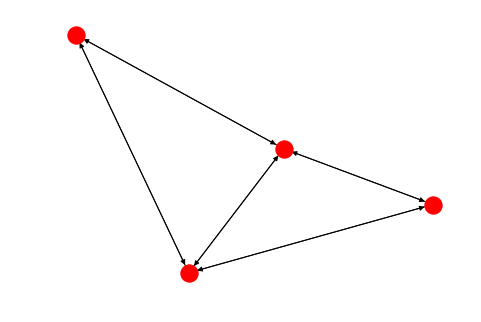

In [18]:
TrafficCost=0
node_list=[0,1,2,3]
SR_pair=[(0,1),(1,0),(1,2),(2,1),(0,2),(2,0),(2,3),(3,2),(0,3),(3,0),(1,3),(3,1)]
edges_list=[(0,1),(1,0),(1,2),(2,1),(0,2),(2,0),(2,3),(3,2),(1,3),(3,1)]
bypassEdges=[]
In_bypassEdges=[]
Out_bypassEdges=[]
for i in range(len(edges_list)):
    BY=[]
    BY0=[]
    BY1=[]
    
    for j in range(7):
        BY.append([])
        BY0.append([])
        BY1.append([])
    bypassEdges.append(BY)
    In_bypassEdges.append(BY0)
    Out_bypassEdges.append(BY1)
    

   
#先对D=2的节点进行bypass设置，在对D=3的节点进行bypass设置
#每次设置都在该link中不存在

G=nx.DiGraph()
G.add_nodes_from(node_list)
G.add_edges_from(edges_list)
nx.draw(G)

#plt.show()


link_list=[] 

for k in range(len(edges_list)):
    link_list0=[]
    for i in range(7):
        link_list0.append(edges_list[k]+(i,)) 
    link_list.append(link_list0)

SD_path=[]
SR_pathLink=[]
for i in range(len(SR_pair)):
    path0=[]
    for path in nx.all_simple_paths(G, source=SR_pair[i][0], target=SR_pair[i][1]):
        path_edges=[]            
        for j in range(len(path)-1):
            path_edges.append((path[j],path[j+1]))
        path0.append(path_edges)
    SD_path.append(path0)


CoreSetup() 
for i in range(len(bypassEdges)):
    Link=bypassEdges[i]
    for j in range(7):
        if(len(Link[j])>0):
            if(Link[j][0][0]==edges_list[i][1]):
                
                Out_bypassEdges[i][j]=Link[j]
            elif(Link[j][0][1]==edges_list[i][0]):
                In_bypassEdges[i][j]=Link[j]

#print(Out_bypassEdges) 
#print(In_bypassEdges)
print(bypassEdges)

In [19]:
SD_pathLink=[]  
for i in range(len(SD_path)):
    Links=[]
    for j in range(len(SD_path[i])):
        Links=Links+edgeToLinks(SD_path[i][j])
        
    SD_pathLink.append(Links)


In [20]:
Total_bandwidth=161
Resource=np.zeros([4,4,7,161]).tolist()
ALL_SD_bandwidth=[]
MaxBand=[]
Hops=[]
Bypass_Type=[]
for i in range(len(SD_pathLink)):
    Band=[]
    Max=[]
    Hhops=[]
    Bypass=[]
    for j in range(len(SD_pathLink[i])):
        Hhops.append(len(SD_pathLink[i][j]))
        b=pathBand(SD_pathLink[i][j])
        Max.append(max(b[:,1] - b[:,0]))
        Band.append(b)
        Bypass.append(bypassType(SD_pathLink[i][j]))
    ALL_SD_bandwidth.append(Band)
    MaxBand.append(Max)
    Hops.append(Hhops)
    Bypass_Type.append(Bypass)


In [21]:
Traffic=pd.read_csv('traffic.csv',sep=',',names=['S','D','band'])
#Traffic=Traffi.sort_values(by=['band'],ascending=[False]) 
#Traffic.reset_index(drop=True, inplace=True)
SuccessFlag=np.zeros(len(Traffic))
traffic_wave=[]
traffic_path=[]
traffic_feedback=[]
#Traffic_num=len(Traffic)
Traffic_num=len(Traffic)
for i in range(500):
    PathFlag=0
    traffic=(Traffic['S'][i],Traffic['D'][i])
    band=Traffic['band'][i]
    traffic_Path=SD_pathLink[SR_pair.index(traffic)]
    traffic_Hops=Hops[SR_pair.index(traffic)]
    traffic_Band=ALL_SD_bandwidth[SR_pair.index(traffic)]
    traffic_Bypass=Bypass_Type[SR_pair.index(traffic)]
    traffic_pathSelection=PathAlgorithm_1(traffic_Path,traffic_Hops,band,traffic_Band,traffic_Bypass)
    traffic_path.append(traffic_pathSelection)
    if(len(traffic_pathSelection)>0):
        Pathloc=traffic_Path.index(traffic_pathSelection)
        #print(Pathloc)
        if(pathBand_Ocuupy(SR_pair.index(traffic),Pathloc,band,i)==1):
            PathFlag=1
            pathUpdate()
    
    if(PathFlag==1):
        SuccessFlag[i]=1
        
print(SuccessFlag) 

    place  bypass  bandwidth  hops   sum
0       4       1        1.0     3   1.0
1      21       1        1.0     3   1.0
2      38       1        1.0     3   1.0
3      55       1        1.0     3   1.0
4      85       0        1.0     1   1.0
5      86       0        1.0     1   1.0
6      87       0        1.0     1   2.0
7      88       0        1.0     1   2.0
8      73       0        1.0     2   1.0
9      74       0        1.0     2   3.0
10     75       0        1.0     2   2.0
11     76       0        1.0     2   1.0
12     77       0        1.0     2   3.0
13     78       0        1.0     2   2.0
14     79       0        1.0     2   1.0
15     80       0        1.0     2   3.0
16     81       0        1.0     2   2.0
17     82       0        1.0     2   1.0
18      5       0        1.0     3   1.0
19      6       0        1.0     3   1.0
20      7       0        1.0     3   1.0
21      8       0        1.0     3   1.0
22      9       0        1.0     3   1.0
23     10       

    place  bypass  bandwidth  hops   sum
0      17       1        1.0     3   1.0
1      34       1        1.0     3   1.0
2      51       1        1.0     3   1.0
3      68       1        1.0     3   1.0
4      85       0        1.0     1   3.0
5      86       0        1.0     1   3.0
6      87       0        1.0     1   3.0
7       1       0        1.0     2   1.0
8       2       0        1.0     2   1.0
9       3       0        1.0     2   1.0
10      4       0        1.0     2   1.0
11      5       0        1.0     2   1.0
12      6       0        1.0     2   1.0
13      7       0        1.0     2   2.0
14      8       0        1.0     2   1.0
15      9       0        1.0     2   2.0
16     10       0        1.0     2   2.0
17     11       0        1.0     2   2.0
18     12       0        1.0     2   2.0
19     13       0        1.0     3   3.0
20     18       0        1.0     3   1.0
21     19       0        1.0     3   1.0
22     20       0        1.0     3   1.0
23     21       

In [22]:
a=SuccessFlag.sum()
print(a)

492.0
